# Automatic Building Footprint Extraction Using Satellite RGB and LiDAR Elevation

This is the "lite" version of building extraction notebook. The purpose of this version is to allow reproduction on free-tier Amazon SageMaker instances. Some network accuracies may be downgraded due to these modifications.

## Setup

_This notebook was created and tested on an ml.t3.medium notebook instance. The Amazon SageMaker offers free-tier ml.t3.medium notebook instances, see [webpage](https://aws.amazon.com/sagemaker/pricing/) for more details._

First of all, if you haven't done so, please follow instructions in `README.md` to run `setup-env.sh` and `download-from-s3.sh` scripts to properly set up the Conda environment and download necessary files from S3 buckets prepared for this tutorial. Before proceeding, make sure this notebook connects with the proper kernel (`conda_[name]`, `[name]` is name of the new Conda environment you just created).

In [1]:
import os, time, json, random
from pathlib import Path
from tqdm import tqdm
from p_tqdm import p_umap
import numpy as np
import pandas as pd
import skimage
import torch
from torch import nn

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### External modules

We made some customized modification to the external module `solaris` in `libs/` directory. Please refer to their [GitHub page](https://github.com/CosmiQ/solaris) for more information.

In [2]:
import libs.solaris as sol

### Plotting preferences

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

## Data

The datasets used in this notebook are saved in directory `./data/buildings/`.

1. **SpaceNet satellite images**:
There are 3850 tiles ("chips") of 200m$\times$200m satellite images/labels in this training dataset (`SN2/AOI_2_Vegas`). See [link](https://spacenet.ai/las-vegas/) for more information. We extract the ~0.3m resolution pan-sharpened RGB (`PS-RGB`) 3-channel satellite images and perform white balancing. On the other hand, the `geojson_buildings/` directory contains GeoJSON files for building ground truths.

2. **USGS 3DEP LiDAR**:
This is [a large USGS project](https://www.usgs.gov/core-science-systems/ngp/3dep) that covers many regions throughout US. Also see [here](https://usgs.entwine.io/) for cool visualizations. We extract 3D point clouds in Las Vegas region that overlap with the SpaceNet data, project them into corresponding 2D tiles (3084 in total). The LiDAR data have two attributes: elevation and reflection intensity. For building extraction, we will use the elevation attribute after normalizing the elevation values.

At the end, we merge the LiDAR elevation attribute as an additional channel to the RGB image, and save these 4-channel images to `RGB+ELEV/` directory.

In [4]:
data_dir = './data/buildings/'
img_dir = os.path.join(data_dir, 'RGB+ELEV')
bldg_dir = os.path.join(data_dir, 'geojson_buildings')

# Prefix of all filename - naming convention
prefix = 'SN2_buildings_train_AOI_2_Vegas_'

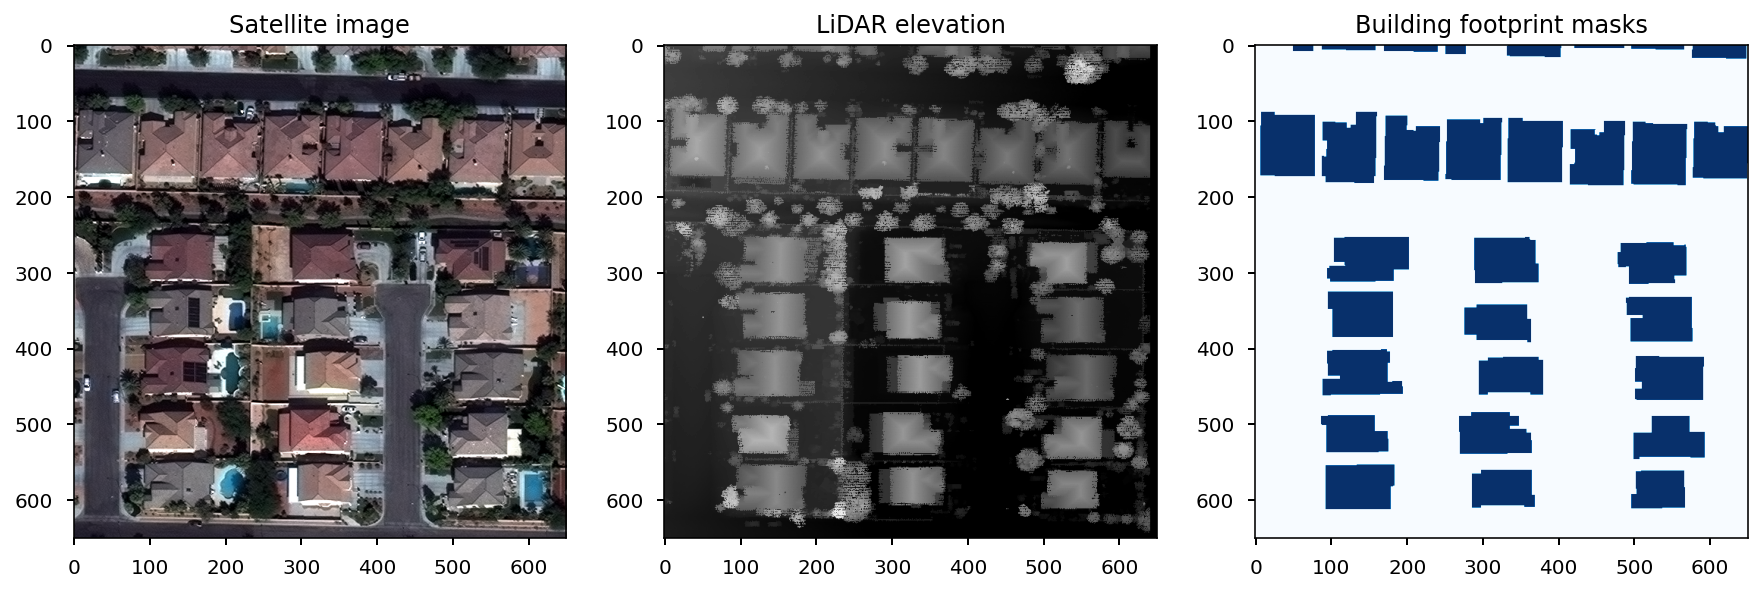

In [5]:
# Show a data sample
sample = 'img1423' # chip ID, img? format

# Read in 4-channel image from GeoTIFF.
img_file = prefix + 'RGB+ELEV_' + sample + '.tif'
img_path = os.path.join(img_dir, img_file)
img = skimage.io.imread(img_path)
rgb = img[..., :3]
elev = img[..., -1]

# Read in GeoJSON file and convert polygons to footprint mask.
bldg_file = prefix + 'geojson_buildings_' + sample + '.geojson'
bldg_path = os.path.join(bldg_dir, bldg_file)
mask = sol.vector.mask.footprint_mask(bldg_path, reference_im=img_path)

# Display satellite image and building footprint mask.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(rgb)
ax[0].set_title('Satellite image')
ax[1].imshow(elev, cmap='gray', vmin=0, vmax=5000)
ax[1].set_title('LiDAR elevation')
ax[2].imshow(mask, cmap='Blues')
ax[2].set_title('Building footprint masks')
fig.show()

### Convert ground truths to masks

The SpaceNet images come with GeoJSON annotations as polygon vectors. These cannot be directly accepted by neural network; instead, we should convert them to binary mask images (as shown above). These masks will be the "ground truth labels" to train our segmentation network model.

In [6]:
mask_dir = os.path.join(data_dir, 'mask_buildings')

# This step is time-consuming, and only needs to be run once.
# After you have all the mask labels ready in folder `mask_buildings/`,
# this operation will be skipped.
if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)
    
    img_file_list = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
    for img_file in tqdm(img_file_list):
        # Get the `img[number]` chip ID from file name.
        chip_id = os.path.splitext(img_file)[0].split('_')[-1]
        bldg_file = prefix + 'geojson_buildings_' + chip_id + '.geojson'
        mask_file = prefix + 'mask_buildings_' + chip_id + '.tif'
        
        _ = sol.vector.mask.footprint_mask(
            os.path.join(bldg_dir, bldg_file),
            out_file=os.path.join(mask_dir, mask_file),
            reference_im=os.path.join(img_dir, img_file))

## Inference on sample data

For this notebook, all training setups in `.yml` format are saved in directory `configs/buildings/`:
1. `RGB-only.yml`: network only uses RGB images as input (3-channel);
2. `ELEV-only.yml`: network only uses LiDAR elevation images as input (1-channel);
3. `RGB+ELEV.yml`: network uses both RGB and LiDAR elevation as merged input (4-channel).

In the following cell, please select the config file you would like to experiment. After completing this notebook, feel free to come back here, change to other config or create your own setup to see what's different.

In [7]:
# --------------------------------------------#
# Select the config file you want to use
config = sol.utils.config.parse('./configs/buildings/RGB+ELEV.yml')
# --------------------------------------------#

Next, let's load a customized VGG16-Unet from `networks/` directory. This algorithm is from the winner `XD_XD` from SpaceNet challenge 4 ([link to repo](https://github.com/SpaceNetChallenge/SpaceNet_Off_Nadir_Solutions/tree/master/XD_XD)). We modified the code so that it takes multi-channel input.

In [8]:
# Load customized multi-channel input VGG16-Unet model.
from networks.vgg16_unet import get_modified_vgg16_unet

custom_model = get_modified_vgg16_unet(
    in_channels=config['data_specs']['channels'])
custom_model_dict = {
    'model_name': 'modified_vgg16_unet',
    'weight_path': config['training']['model_dest_path'],
    'weight_url': None,
    'arch': custom_model}
config['train'] = False
# Modification to reduce RAM cost, may impact prediction accuracy.
config['batch_size'] = 1
config['data_specs']['width'] = 512
config['data_specs']['height'] = 512
inferer = sol.nets.infer.Inferer(config, custom_model_dict=custom_model_dict)

sample_df = pd.DataFrame({'image': [img_path]}) # previous sample image
inferer(sample_df)

100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


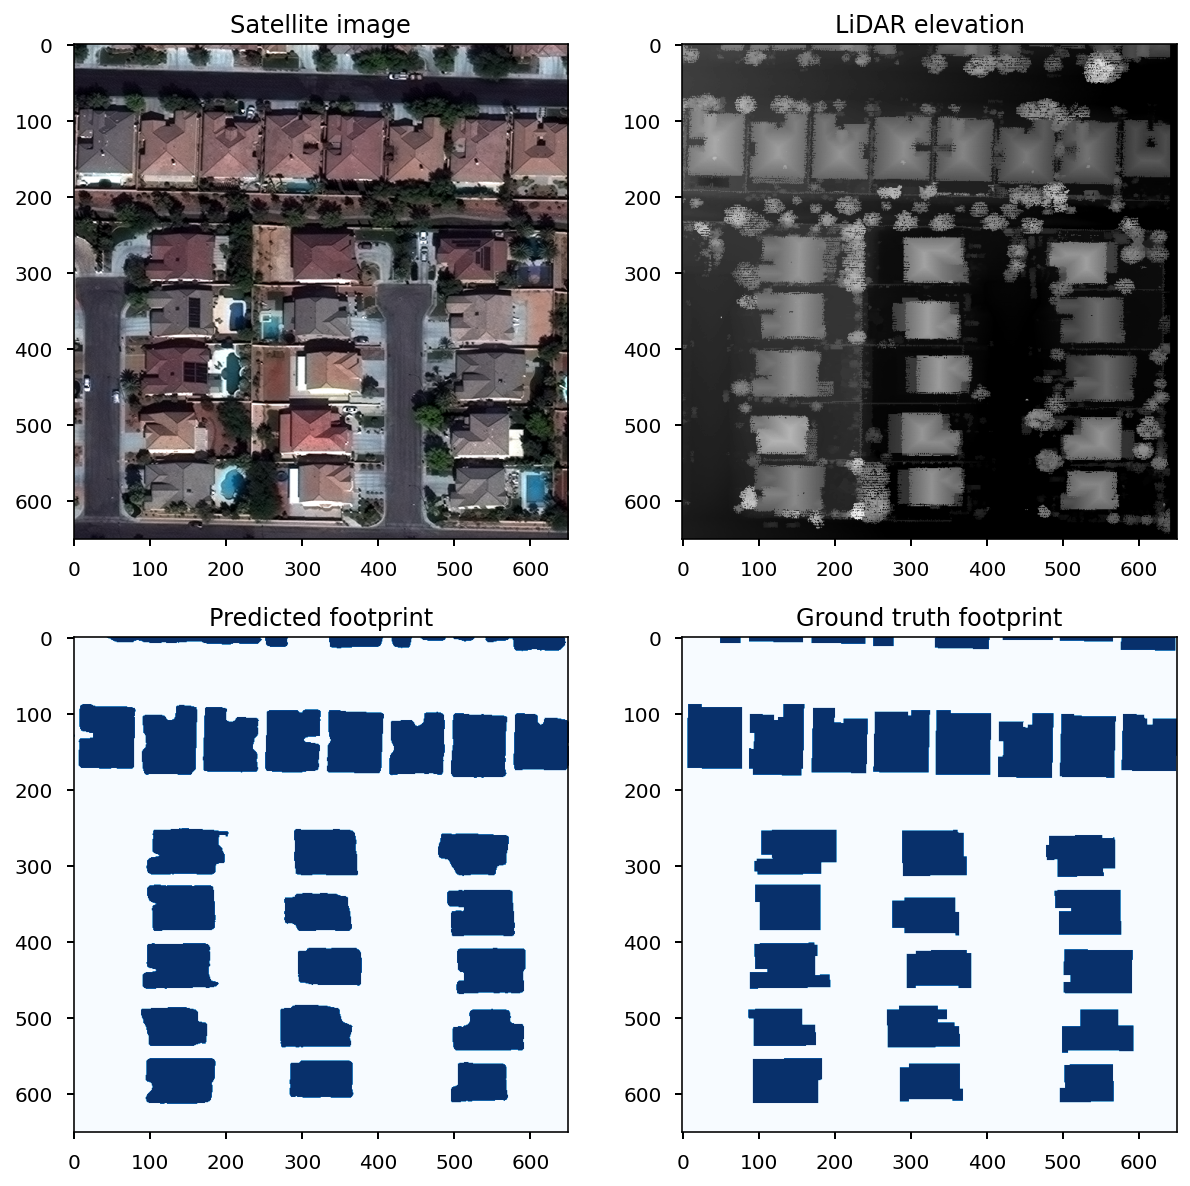

In [9]:
# Load prediction result from the output directory.
pred_dir = config['inference']['output_dir']
pred_file = prefix + 'RGB+ELEV_' + sample + '.tif'
pred_path = os.path.join(pred_dir, pred_file)
pred = skimage.io.imread(pred_path)[..., 0]

# Display satellite image, LiDAR, prediction mask, and ground truth mask.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(rgb)
ax[0][0].set_title('Satellite image')
ax[0][1].imshow(elev, cmap='gray', vmin=0, vmax=5000)
ax[0][1].set_title('LiDAR elevation')
ax[1][0].imshow(pred>0, cmap='Blues')
ax[1][0].set_title('Predicted footprint')
ax[1][1].imshow(mask, cmap='Blues')
ax[1][1].set_title('Ground truth footprint')
fig.show()

The result looks good. Meanwhile, other than visual comparison, a quantitative metric can help us better understand the model's performance. SpaceNet building extraction challenge evaluates models by F-1 scores for IoU>=50%. Now let's evaluate the F-1 score of the result above.

In [10]:
# We convert GeoJSON polygons to binary masks for training and visualization;
# similarly, now we will do the reverse: convert prediction masks
# to polygon GeoJSON as "proposal".
results_dir = Path(config['inference']['output_dir']).parent
prop_dir = os.path.join(results_dir, 'prop_geojson')
os.makedirs(prop_dir, exist_ok=True)
prop_file = bldg_file # same filename as the ground truth GeoJSON
prop_path = os.path.join(prop_dir, prop_file)
prop = sol.vector.mask.mask_to_poly_geojson(
    pred_arr=pred,
    reference_im=img_path,
    do_transform=True,
    min_area=1e-10,
    output_path=prop_path
) # save to geojson file in the output folder

# Create evaluator and load the ground truth.
evaluator = sol.eval.base.Evaluator(bldg_path)

# Evaluate F-1 score by IoU>=50% detections.
evaluator.load_proposal(prop_path, conf_field_list=[]) # only one class
score = evaluator.eval_iou(miniou=0.5, calculate_class_scores=False)
score_df = pd.DataFrame.from_records(score)
score_df

,class_id,iou_field,TruePos,FalsePos,FalseNeg,Precision,Recall,F1Score
0,all,iou_score_all,26,4,5,0.866667,0.83871,0.852459


## Infer on Random Image

In this section, we visually check some results. The next cell randomly sample from the result list. Rerun as many times as you wish to see different figures.

In [11]:
# Get list of available images.
img_file_list = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
img_file_list.sort()

100%|██████████| 1/1 [00:08<00:00,  8.07s/it]


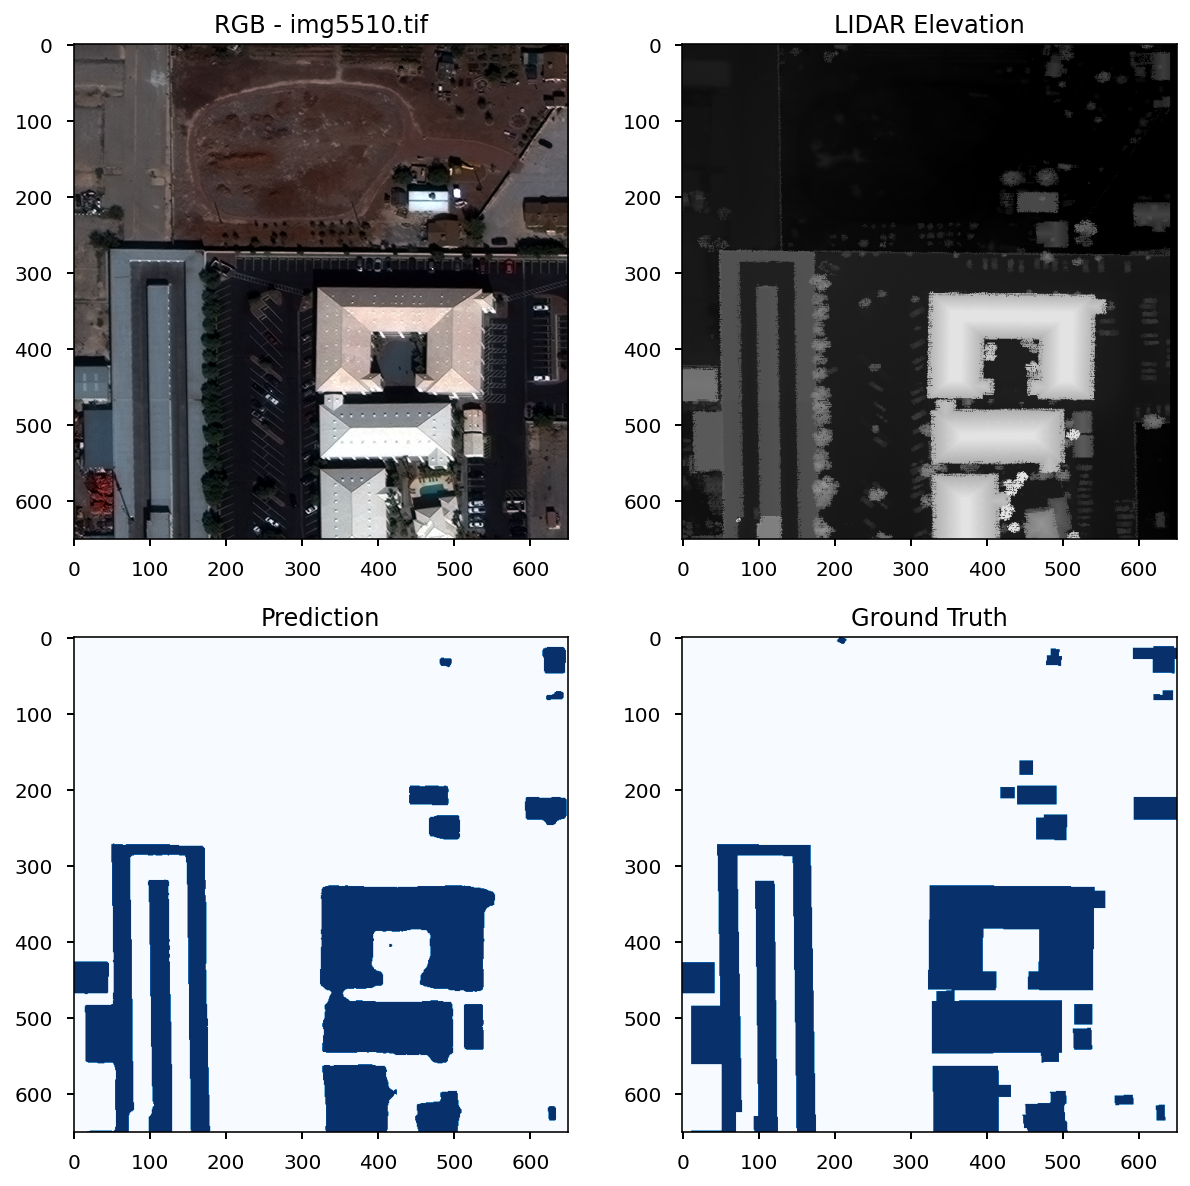

In [12]:
# Randomly check the network predictions. Feel free to rerun this cell!
file = random.choice(img_file_list)
# Or you can select the 'img1423.tif' we saw before.
# file = 'SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img1423.tif'
img_path = os.path.join(img_dir, file)
pred_path = os.path.join(pred_dir, file)
mask_path = os.path.join(mask_dir, file.replace('RGB+ELEV', 'mask_buildings'))

# Perform one-time inference on the selected image.
infer_df = pd.DataFrame({'image': [img_path]})
inferer(infer_df)

# Visualize the result.
img = skimage.io.imread(img_path)
rgb = img[..., :3]
elev = img[..., -1]
pred = skimage.io.imread(pred_path)[..., 0]
mask = skimage.io.imread(mask_path)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(rgb)
ax[0][0].set_title('RGB - {}'.format(file.split('_')[-1]))
ax[0][1].imshow(elev, cmap='gray', vmin=0, vmax=5000)
ax[0][1].set_title('LIDAR Elevation')
ax[1][0].imshow(pred>0, cmap='Blues')
ax[1][0].set_title('Prediction')
ax[1][1].imshow(mask, cmap='Blues')
ax[1][1].set_title('Ground Truth')
fig.show()